# Analiza szeregów czasowych w Pythonie

### Szereg czasowy - co to?

to ciąg informacji uporządkowanych w czasie, których pomiary wykonywane są z *dokładnym* krokiem czasowym.

![image.png](attachment:image.png)

![image.png](attachment:image.png)

### Typowe statystyki

### ACF i PACF

### AR, MA, ARIMA

### Biblioteka PROPHET

### FFT

### Sieci neuronowe - how to?

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff


import pmdarima as pm
from pmdarima.model_selection import train_test_split

from numpy.fft import rfft, irfft, rfftfreq
from numpy import fft
from scipy import pi, signal, fftpack

import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import prophet

In [2]:
import warnings
warnings.filterwarnings('ignore')

![image.png](attachment:image.png)

# Wczytanie danych i wstępne czyszczenie

In [362]:
def ADF_test(data):
    #ADF statistic to check stationarity
    t = data
    timeseries = adfuller(t)
    print('ADF Statistic: %f' % timeseries[0])
    print('p-value: %f' % timeseries[1])
    print('Critical Values:')

    for key, value in timeseries[4].items():
        print('\t%s: %.3f' % (key, value))
        if timeseries[0] > timeseries[4]["5%"]:
            print ("Failed to Reject Ho - Time Series is Non-Stationary")
        else:
            print ("Reject Ho - Time Series is Stationary")

In [413]:
# http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/03/03_TrendSeasonTS_Python_updated.html
def tsdisplay(y, figsize = (14, 8), title = "", lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Time\ Series\ " + title + "$", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40, normed = 1)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.show()

### MA

![image.png](attachment:image.png)

![image.png](attachment:image.png)

### AR

![image.png](attachment:image.png)

### ARMA

![image.png](attachment:image.png)

# ARIMA

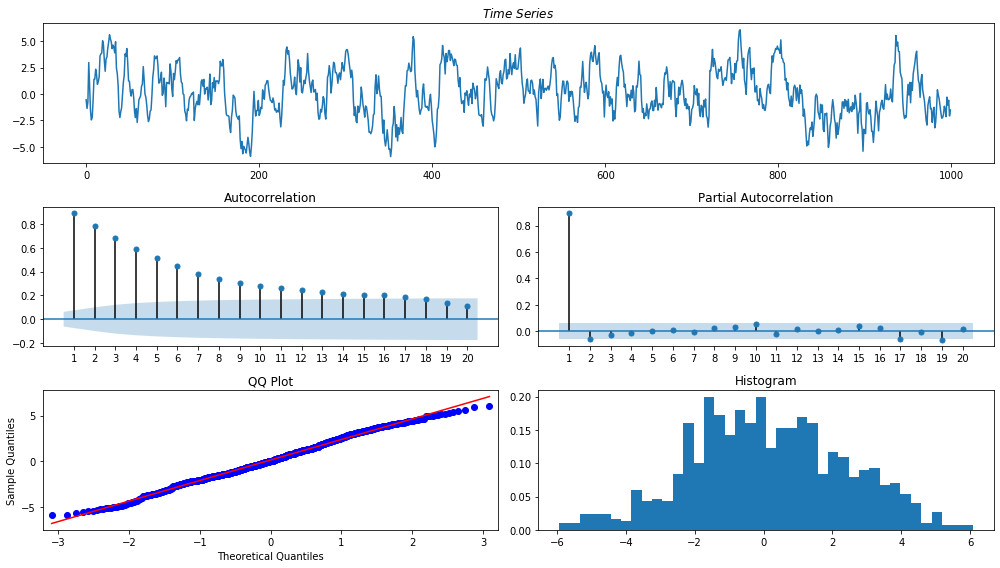

In [607]:
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess

#plt.subplot(2,1,1)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
#plt.plot(simulated_data_1)

tsdisplay(simulated_data_1)

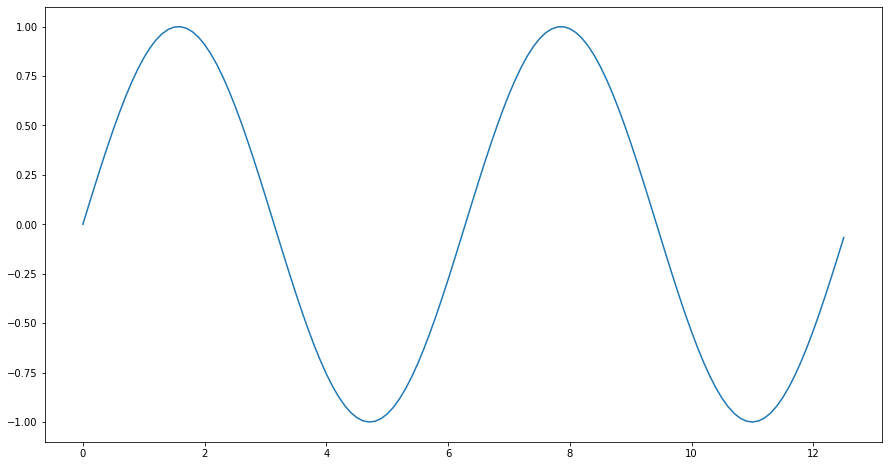

In [608]:
x = np.arange(0,4*np.pi, 0.1)   # start,stop,step
y = np.sin(x)
plt.plot(x,y)

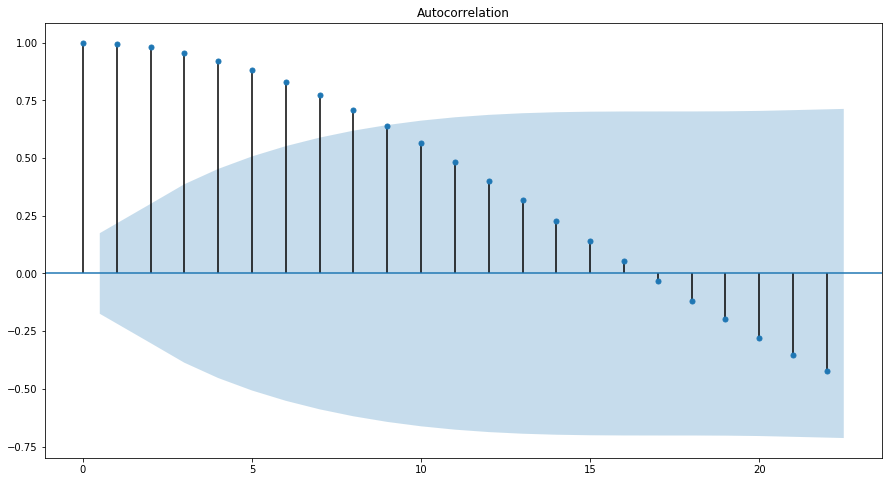

In [609]:
plot_acf(y);

### ACF
* dodatnie i powoli zanikające wartości ACF - sufestia, że dane zawierają deterministyczną składową trendu
* ACF zanikająca i cykliczna - trend sezonowy

### PACF
* Duża wartość dla lag = 1 może świadczyć o silnym trendzie wzrostowym
* Przydatnia dla identyfikacji modeli autoregresyjnych

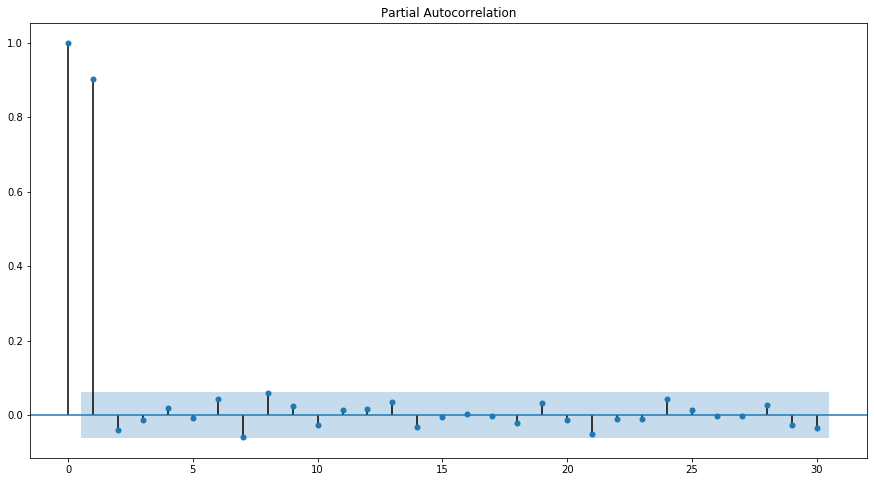

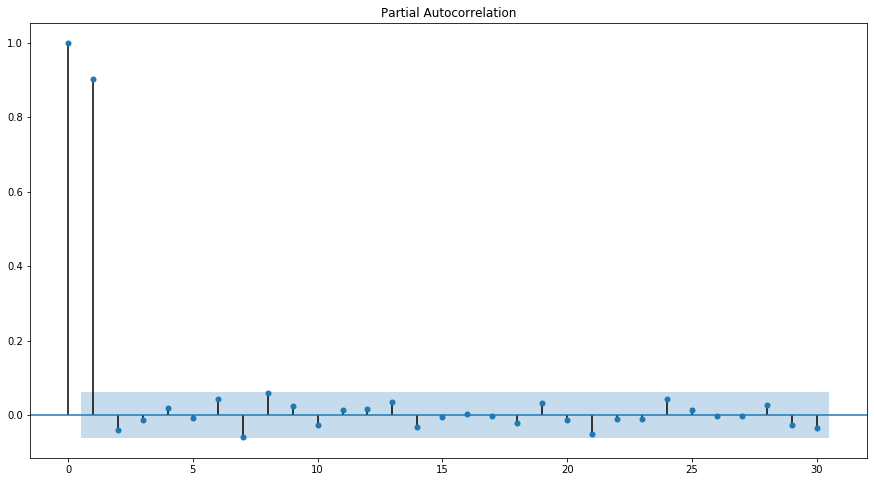

In [605]:
plot_pacf(simulated_data_1)

### AirPassangers

Dane pochodzą z https://www.kaggle.com/rakannimer/air-passengers

In [567]:
airpass = pd.read_csv('AirPassengers.csv')

airpass['ds'] = pd.to_datetime(airpass.Month)
airpass.drop('Month', axis=1, inplace=True)

airpass['y'] = airpass['#Passengers']
airpass.drop('#Passengers', axis=1, inplace=True)

airpass.set_index('ds', inplace=True)
airpass.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


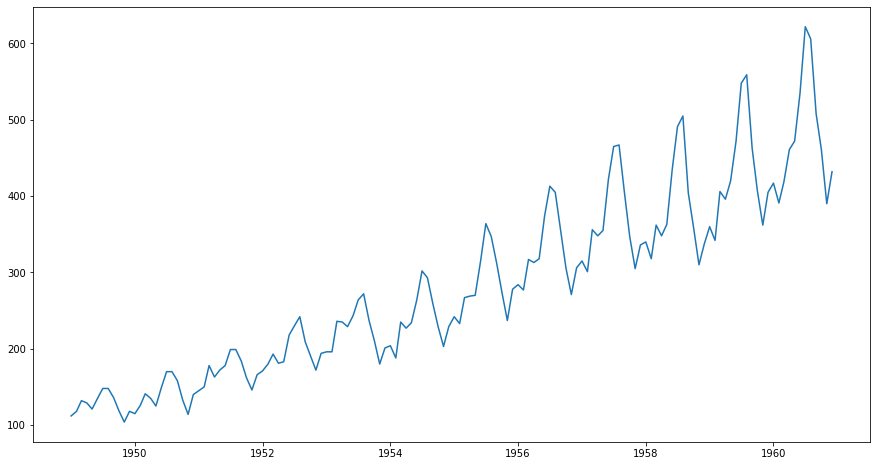

In [568]:
plt.plot(airpass)

In [571]:
airpass.groupby(airpass.index.year)[['y']].describe()

y                                                            
     count        mean        std    min     25%    50%     75%    max
ds                                                                    
1949  12.0  126.666667  13.720147  104.0  118.00  125.0  135.25  148.0
1950  12.0  139.666667  19.070841  114.0  125.75  137.5  151.25  170.0
1951  12.0  170.166667  18.438267  145.0  159.00  169.0  179.50  199.0
1952  12.0  197.000000  22.966379  171.0  180.75  192.0  211.25  242.0
1953  12.0  225.000000  28.466887  180.0  199.75  232.0  238.50  272.0
1954  12.0  238.916667  34.924486  188.0  221.25  231.5  260.25  302.0
1955  12.0  284.000000  42.140458  233.0  260.75  272.0  312.75  364.0
1956  12.0  328.250000  47.861780  271.0  300.50  315.0  359.75  413.0
1957  12.0  368.416667  57.890898  301.0  330.75  351.5  408.50  467.0
1958  12.0  381.000000  64.530472  310.0  339.25  360.5  411.75  505.0
1959  12.0  428.333333  69.830097  342.0  387.50  406.5  465.25  559.0
1960  12.0  476.166667  77.737125  390.0  418.50  461.0  514.75  622.0

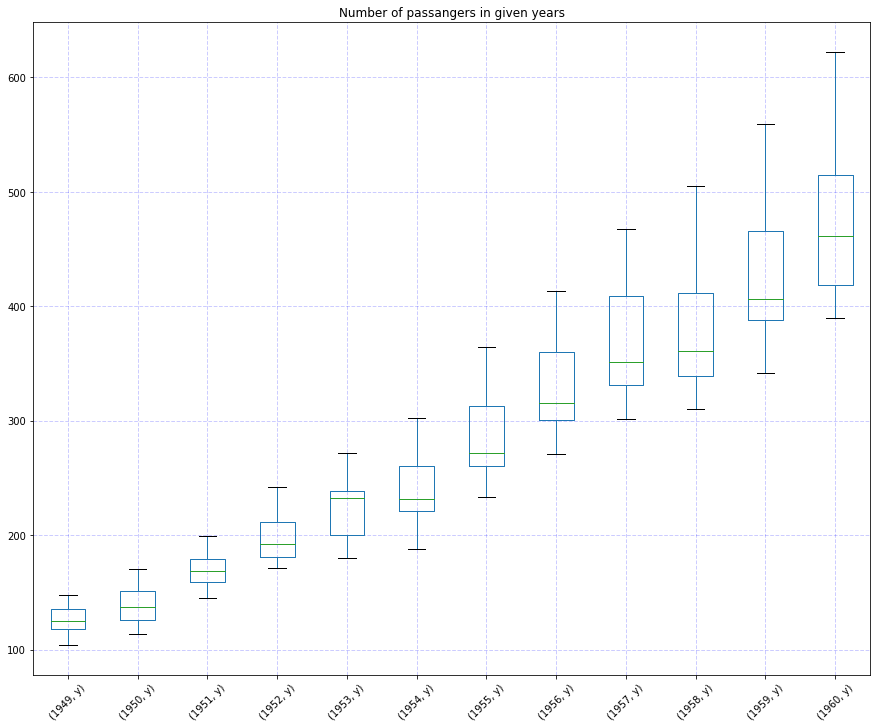

In [572]:
airpass.groupby(airpass.index.year)[['y']].boxplot('y', figsize=(15, 12))
                                                          
plt.title("Number of passangers in given years")                                                        
plt.xticks(rotation=45)
plt.grid(color='b', linestyle='--', linewidth=1, alpha=0.2)
plt.show()

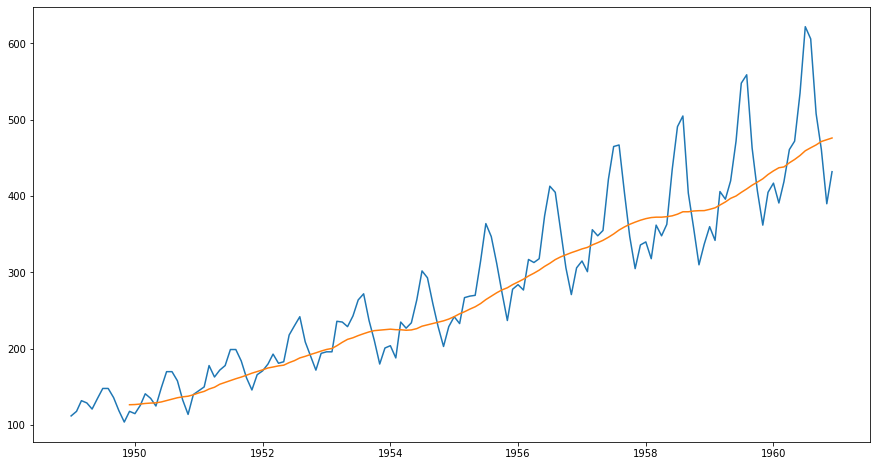

In [472]:
plt.plot(airpass)
plt.plot(airpass.rolling(12).mean())

In [399]:
data_to_plot = pd.pivot_table(airpass, index = airpass.index.month, columns = airpass.index.year)
data_to_plot.head()

y                                                       
ds 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960
ds                                                            
1   112  115  145  171  196  204  242  284  315  340  360  417
2   118  126  150  180  196  188  233  277  301  318  342  391
3   132  141  178  193  236  235  267  317  356  362  406  419
4   129  135  163  181  235  227  269  313  348  348  396  461
5   121  125  172  183  229  234  270  318  355  363  420  472

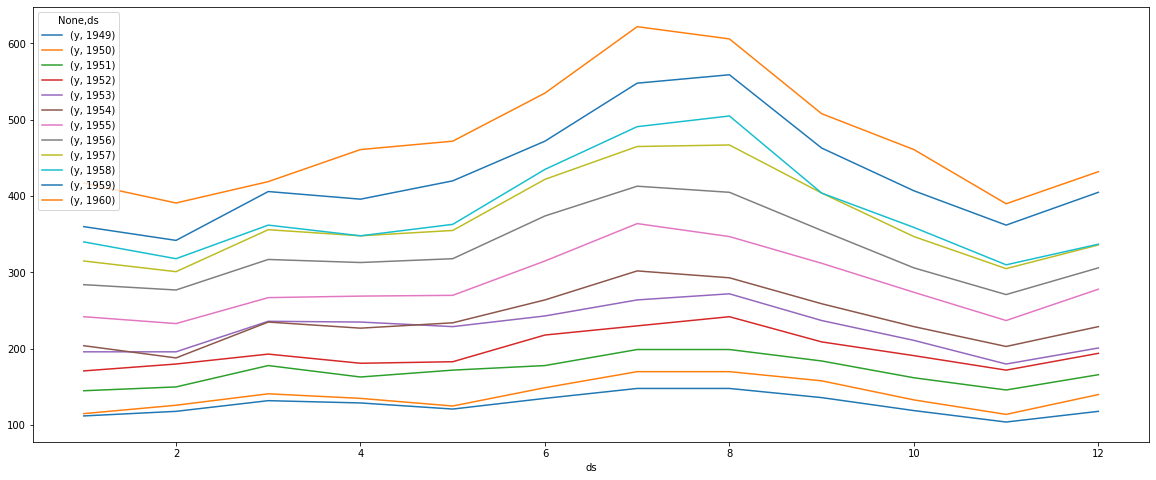

In [401]:
fig = plt.figure(figsize = (20, 8))
data_to_plot.plot(ax = fig.add_subplot(111))
plt.show()

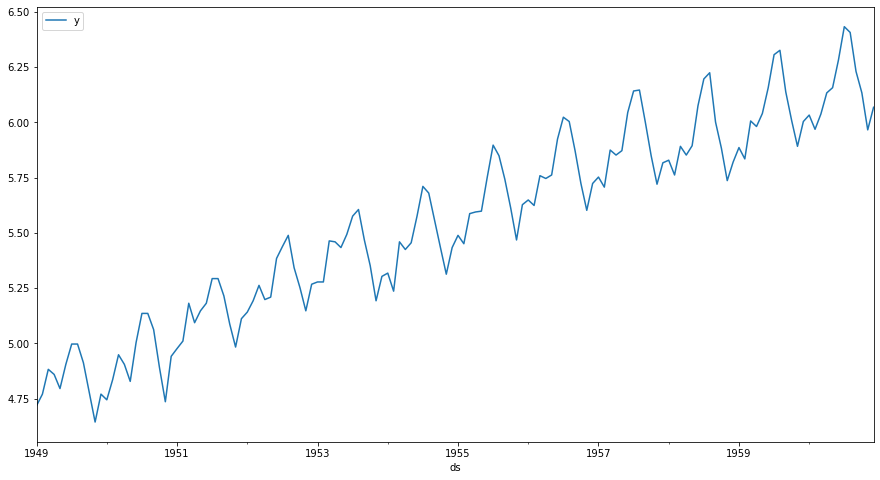

In [423]:
log_airpass = np.log(airpass)
log_airpass.plot()

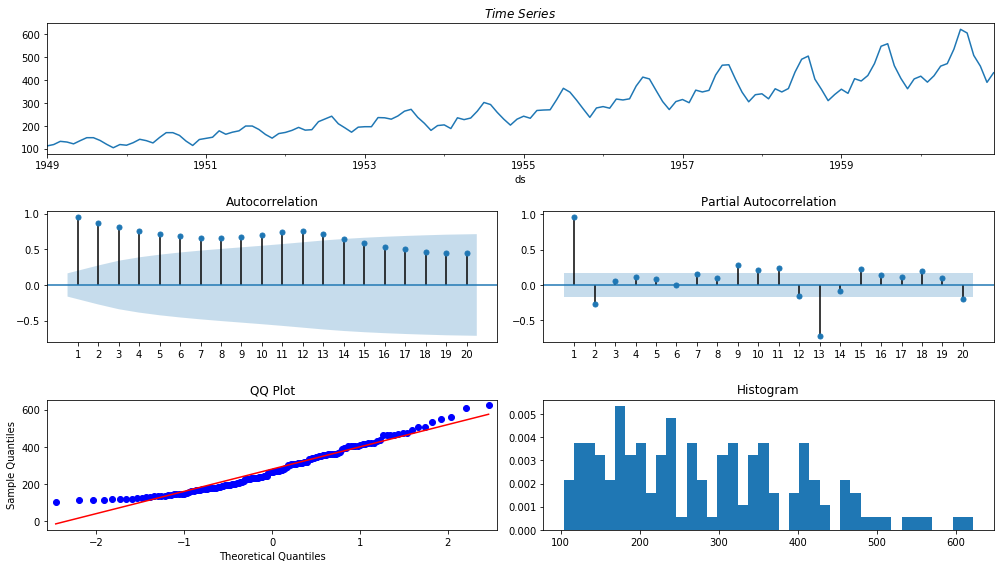

In [426]:
tsdisplay(airpass.y)

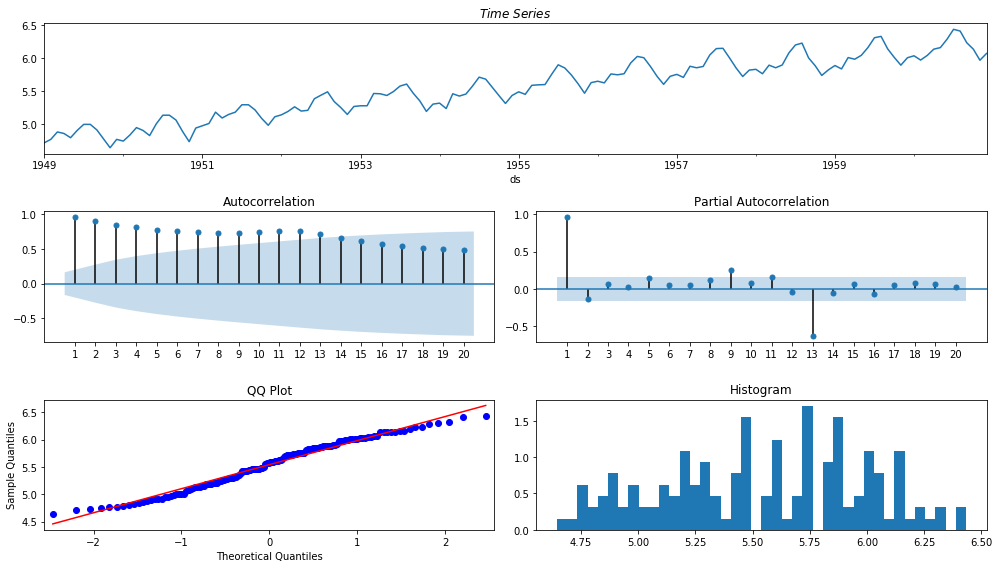

In [427]:
tsdisplay(np.log(airpass.y))

In [428]:
airpass.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


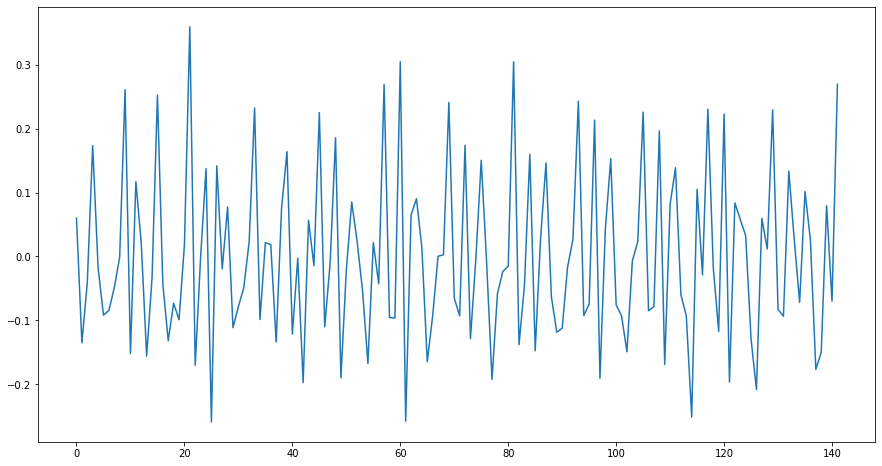

In [615]:
d = 2
y = diff(log_airpass.y, k_diff=d)

plt.plot(np.arange(len(y)), y);

In [616]:
ADF_test(y)

ADF Statistic: -8.196629
p-value: 0.000000
Critical Values:
	1%: -3.483
Reject Ho - Time Series is Stationary
	5%: -2.884
Reject Ho - Time Series is Stationary
	10%: -2.579
Reject Ho - Time Series is Stationary


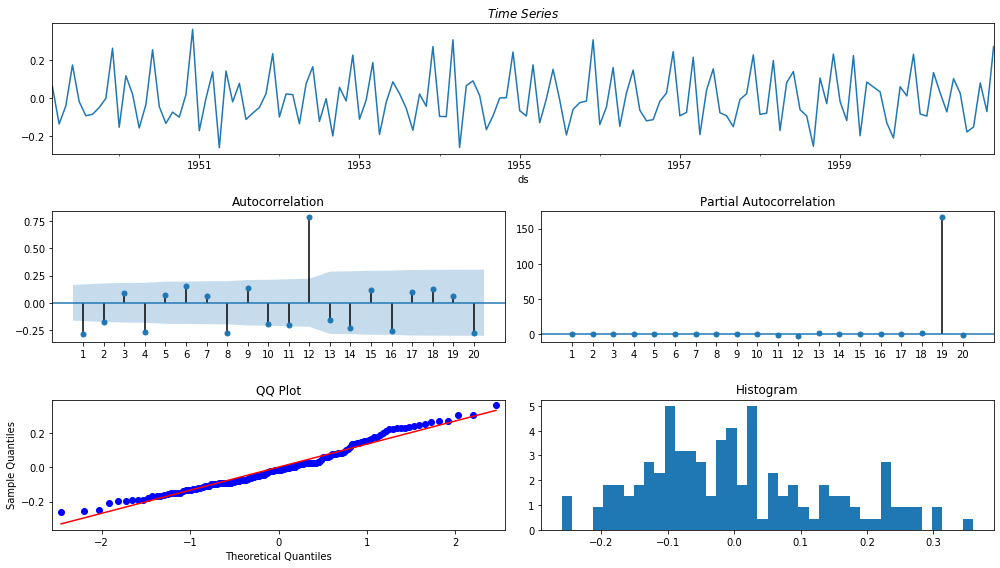

In [617]:
tsdisplay(y)

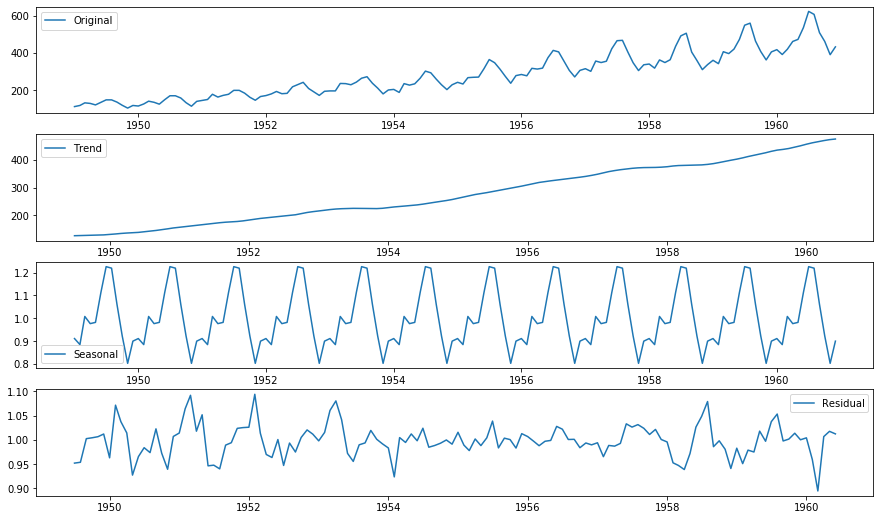

In [619]:
original_series = airpass.y

decompose = seasonal_decompose(original_series, model='multiplicative')

trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid

plt.figure(figsize = (15, 9))
plt.subplot(411)
plt.plot(airpass.y, label = 'Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc='best')

plt.show()

In [365]:
diff(airpass_df.y)

1       6.0
2      14.0
3      -3.0
4      -8.0
5      14.0
       ... 
139   -16.0
140   -98.0
141   -47.0
142   -71.0
143    42.0
Name: y, Length: 143, dtype: float64

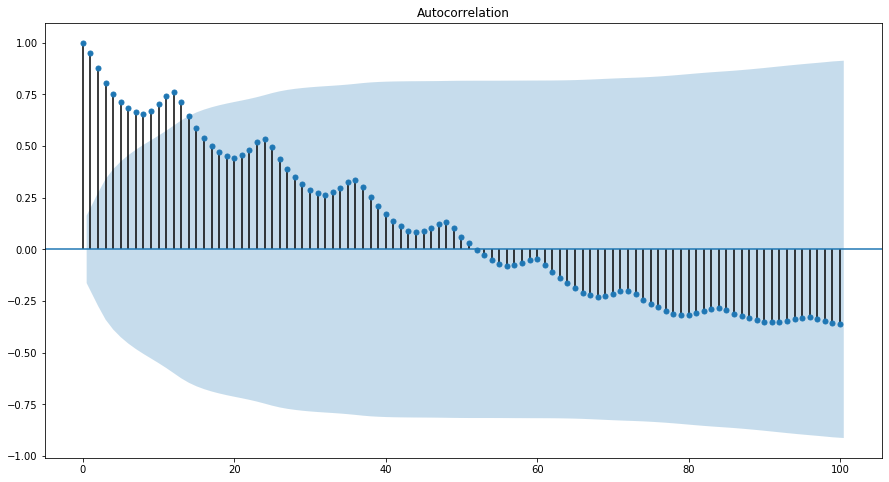

In [433]:
plt.rcParams["figure.figsize"] = (15, 8)

plot_acf(airpass, lags=100);

Autokorelacja dajne nam obraz liniowego powiązania pomiędzy danymi znajdującymi się w szeregu w zależności od odległości pomiędzy nimi.

In [435]:
%%time

airpass_model = pm.auto_arima(airpass.y, seasonal=True, m=12)
airpass_model

Wall time: 4.64 s


ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

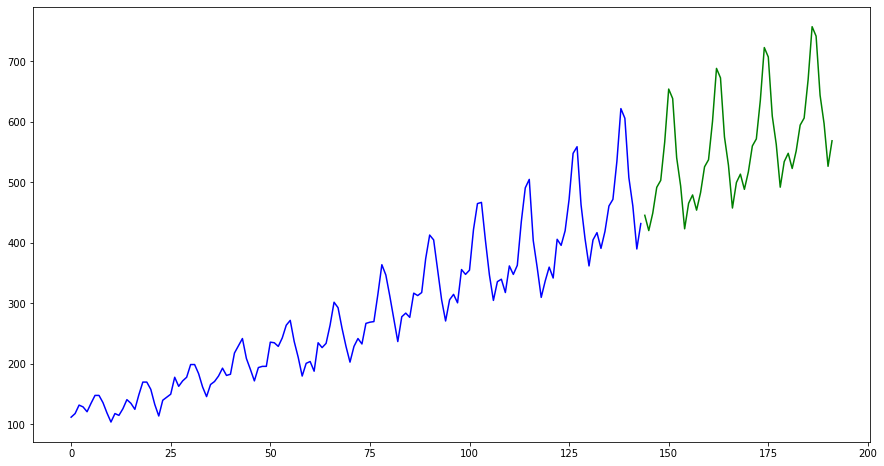

In [621]:
N=48
forecasts = airpass_model.predict(N) 

x = np.arange(len(airpass.y)+N)

plt.plot(x[:-N], airpass.y, c='blue')
plt.plot(x[-N:], forecasts, c='green')

### Temperatura

In [38]:
temp_data = pd.read_csv('https://gist.githubusercontent.com/fischerbach/47985e9fb0a331d2aebba303fb3d5ad1/raw/b06b938dc193b326e7e2edb836c19d12ba4295d1/weather.csv')

temp_data['ds'] = pd.to_datetime(temp_data['ds'])

temp_data.set_index('ds', inplace=True)
temp_data.head()

,temperature
ds,
2008-01-01,0.496808
2008-01-02,-2.821108
2008-01-03,-5.755692
2008-01-04,-7.374025
2008-01-05,-6.109025


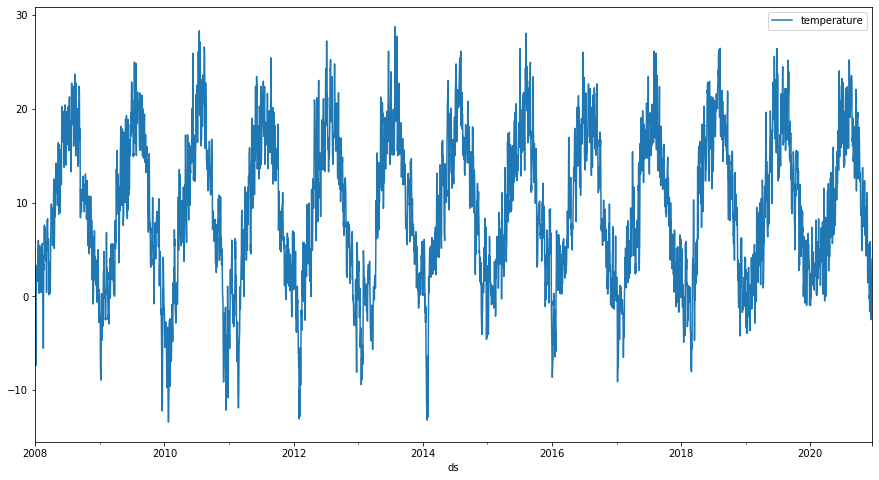

In [40]:
temp_data.plot();

## FastFourier Transform

![image.png](attachment:image.png)

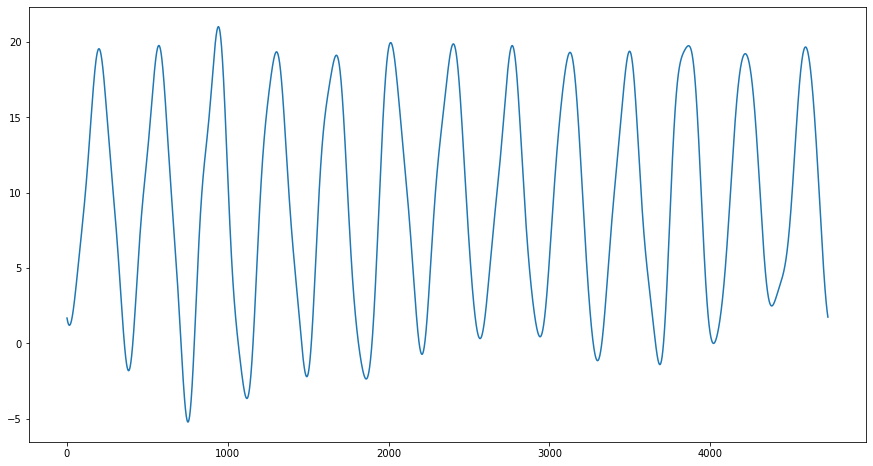

In [131]:
#credits: https://colab.research.google.com/drive/10VADEg8F5t_FuryEf_ObFfeIFwX-CxII?usp=sharing#scrollTo=-0wekbUzqz0H

def low_pass(s, threshold=2e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-3 / s.size)
    #display(1/frequencies)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

temp_smoothed=low_pass(temp_data.temperature)
plt.plot(temp_smoothed);

In [152]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 15                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

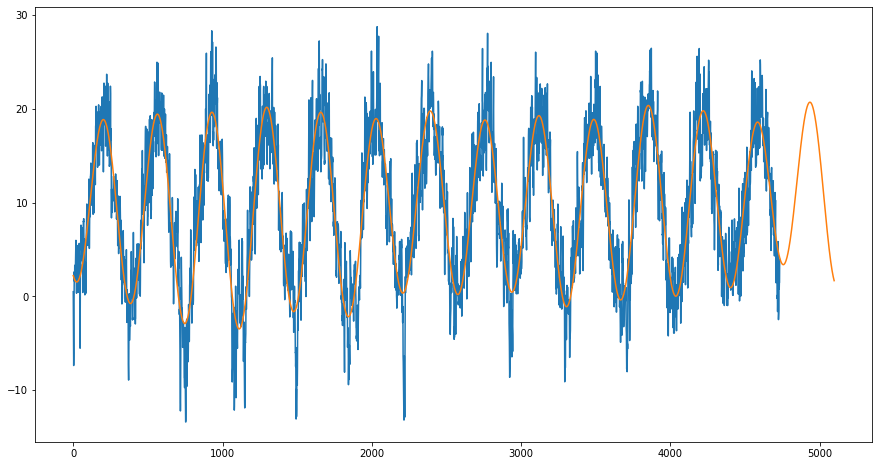

In [154]:
extrapolation = fourierExtrapolation(temp_data.temperature, 365)
plt.plot(temp_data.temperature.values)
plt.plot(extrapolation)

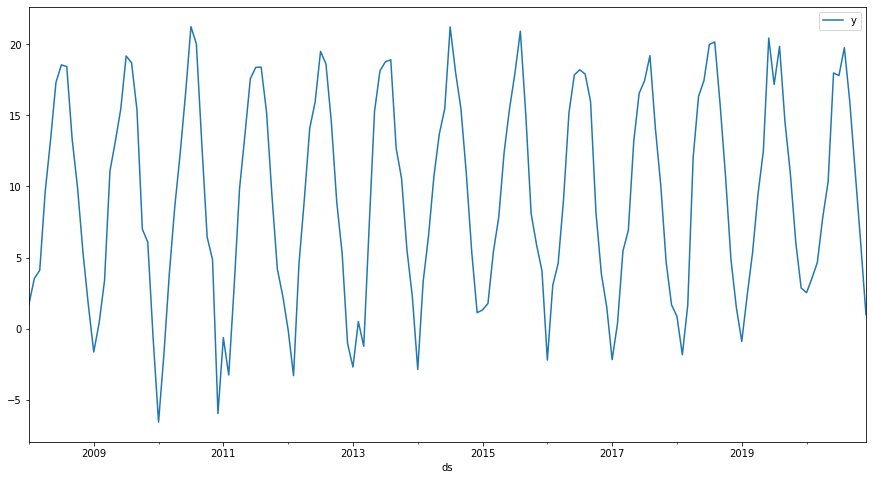

In [584]:
temp_data.set_index('ds').resample('M').mean().plot()

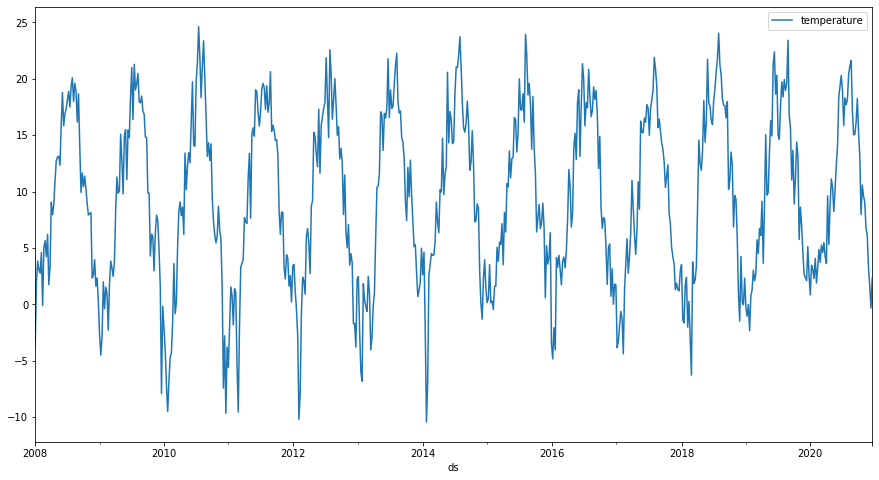

In [84]:
temp_w_data = temp_data.resample('W').mean()
temp_w_data.plot();

In [202]:
%%time
years = 2
weeks_in_year = 52

temp_model = pm.auto_arima(temp_w_data.temperature[-(weeks_in_year*years):], seasonal=True, m=weeks_in_year)

Wall time: 33.3 s


In [206]:
temp_model

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 52),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

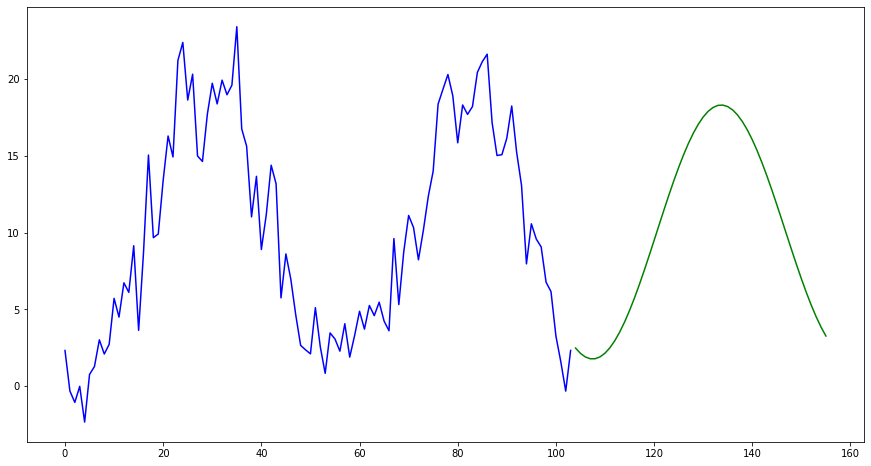

In [203]:
N = 52
forecasts = temp_model.predict(N)  # predict N steps into the future

x = np.arange(weeks_in_year*years+N)

plt.plot(x[:104], temp_w_data.temperature[-104:], c='blue')
plt.plot(x[104:], forecasts, c='green')
plt.show()

In [441]:
ADF_test(temp_w_data)

ADF Statistic: -12.481967
p-value: 0.000000
Critical Values:
	1%: -3.440
Reject Ho - Time Series is Stationary
	5%: -2.866
Reject Ho - Time Series is Stationary
	10%: -2.569
Reject Ho - Time Series is Stationary


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021EE36B3D08>]],
      dtype=object)

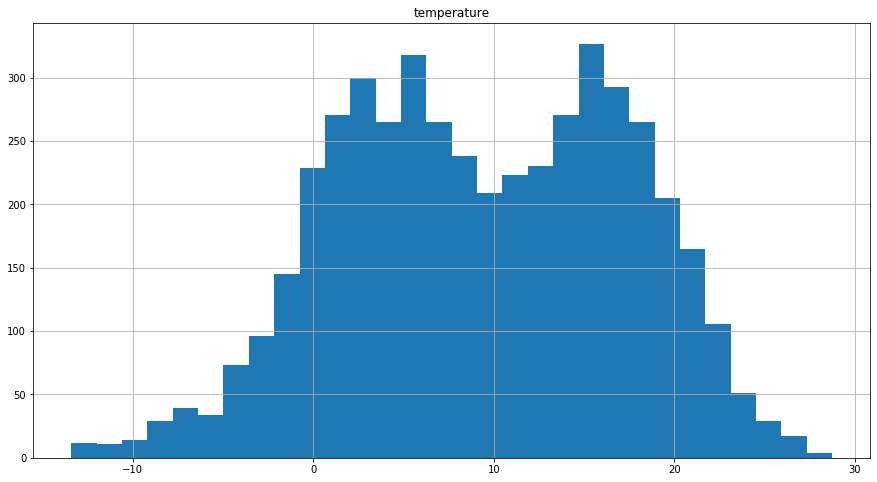

In [103]:
temp_data.hist(bins=30)

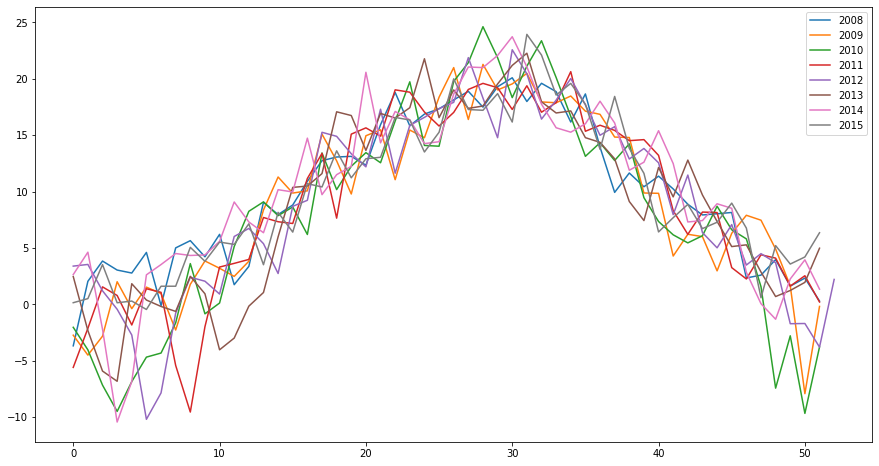

In [81]:
for year in range(2008, 2016):
    plt.plot(temp_w_data[str(year)].reset_index(drop=True), label=str(year))

plt.legend();

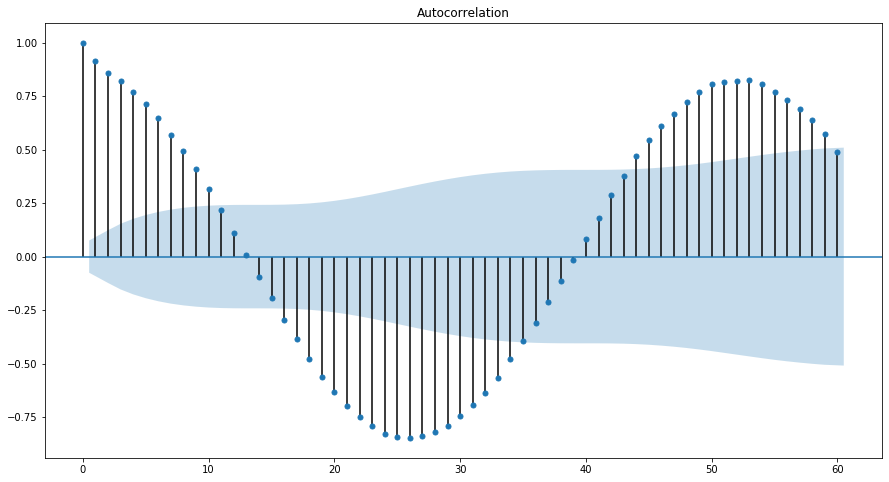

In [60]:
plot_acf(temp_w_data, lags=60);

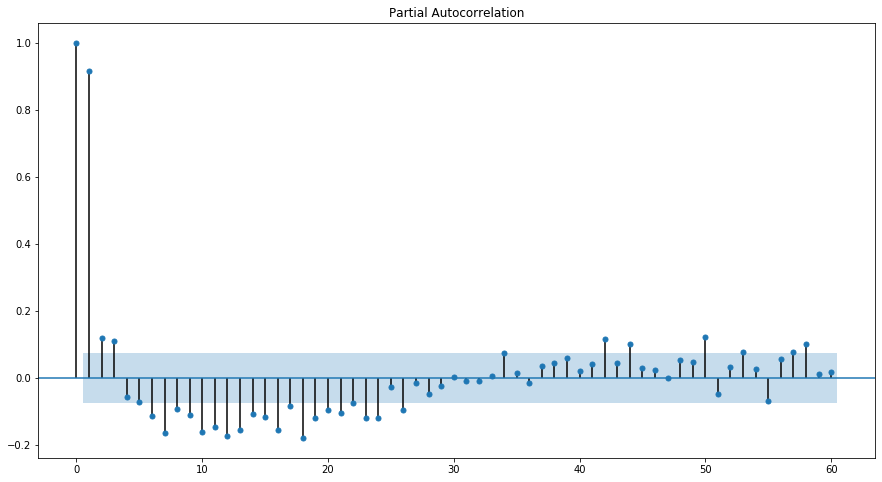

In [62]:
plot_pacf(temp_w_data, lags=60, method='ols');

### Prophet

In [445]:
airpass.reset_index()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [446]:
model = prophet.Prophet()
model.fit(airpass.reset_index())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [449]:
airpass.reset_index().ds.max()

Timestamp('1960-12-01 00:00:00')

In [455]:
future = list()
for i in range(1, 13):
    date = '1961-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

In [456]:
forecast = model.predict(future)

In [457]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 1961-01-01  465.712704  437.441096  493.871521
1 1961-02-01  460.055941  430.919557  488.458974
2 1961-03-01  493.108252  466.459920  523.796608
3 1961-04-01  491.495702  461.624379  519.900742
4 1961-05-01  495.888675  466.382624  525.225631


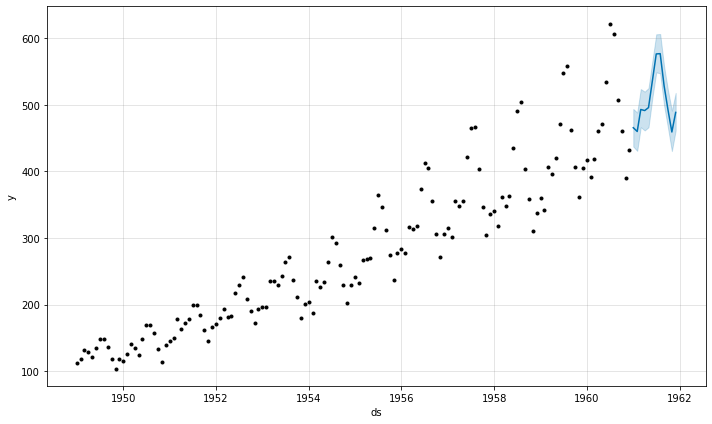

In [458]:
model.plot(forecast);

![image.png](attachment:image.png)

In [495]:
temp_data.columns = ['y']
temp_data.reset_index(inplace=True)
train, test = temp_data[:3787], temp_data[3787:]

In [496]:
model_temp_prophet.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [501]:
forecast_temp = model_temp_prophet.predict(test[['ds']])

In [506]:
test.ds

3787   2018-05-15
3788   2018-05-16
3789   2018-05-17
3790   2018-05-18
3791   2018-05-19
          ...    
4729   2020-12-12
4730   2020-12-13
4731   2020-12-14
4732   2020-12-15
4733   2020-12-16
Name: ds, Length: 947, dtype: datetime64[ns]

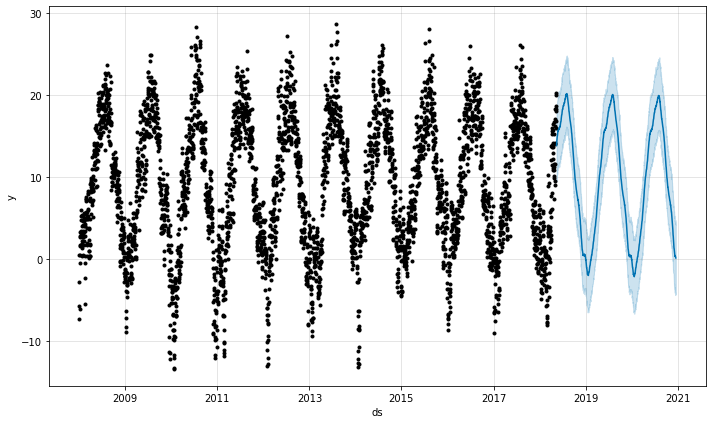

In [507]:
model_temp_prophet.plot(forecast_temp);

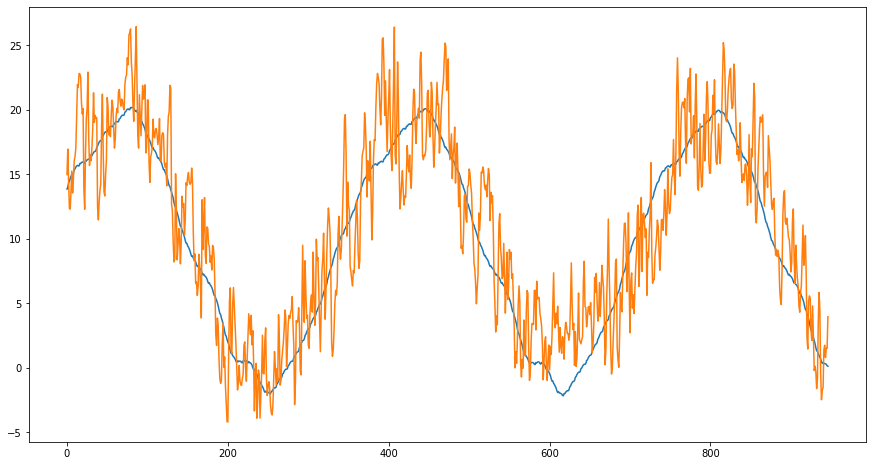

In [514]:
plt.plot(forecast_temp.yhat)
plt.plot(test.reset_index(drop=True)[['y']])

In [513]:
test.reset_index(drop=True)[['y']]

,y
0,14.978058
1,16.962225
2,14.365558
3,12.349725
4,12.295558
...,...
942,1.747225
943,0.802642
944,1.512642
945,1.501392


# Jakie mamy dane ?

# Wstępne czyszczenie danych

In [ ]:
df.groupby(df.YearMonth.dt.year)[['NoPassengers']].boxplot('NoPassengers', figsize=(15, 12))
                                                          
plt.title("Number of passangers in given years")                                                        
plt.xticks(rotation=45)
plt.grid(color='b', linestyle='--', linewidth=1, alpha=0.2)
plt.show()

In [ ]:
df = df.set_index('YearMonth')
df.head()

# Sieci neuronowe?

In [460]:
dataset = np.array(pm.datasets.load_airpassengers()).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [461]:
train_size = int(len(dataset)*0.7)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print('train_size : {}, test_size : {}'.format(len(train),len(test)))

train_size : 100, test_size : 44


In [462]:
timestamp=10
dataX = []
dataY = []
for i in range(len(train)-timestamp-1):
    a = train[i:(i+timestamp),0]
    dataX.append(a)
    dataY.append(train[i+timestamp,0])
trainX = np.array(dataX)
trainY = np.array(dataY)

timestep=10
dataX = []
dataY = []
for i in range(len(test)-timestamp-1):
    a = test[i:(i+timestamp),0]
    dataX.append(a)
    dataY.append(test[i+timestamp,0])
testX = np.array(dataX)
testY = np.array(dataY)

In [463]:
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [622]:
trainX[:5]

array([[[0.01544402, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
         0.05984556, 0.08494208, 0.08494208, 0.06177606, 0.02895753]],

       [[0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984556,
         0.08494208, 0.08494208, 0.06177606, 0.02895753, 0.        ]],

       [[0.05405405, 0.04826255, 0.03281853, 0.05984556, 0.08494208,
         0.08494208, 0.06177606, 0.02895753, 0.        , 0.02702703]],

       [[0.04826255, 0.03281853, 0.05984556, 0.08494208, 0.08494208,
         0.06177606, 0.02895753, 0.        , 0.02702703, 0.02123552]],

       [[0.03281853, 0.05984556, 0.08494208, 0.08494208, 0.06177606,
         0.02895753, 0.        , 0.02702703, 0.02123552, 0.04247104]]])

In [464]:
# model
model = Sequential()
model.add(LSTM(10, input_shape=(1, timestamp))) # 10 lstm neuron(block)
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1)

Train on 89 samples
Epoch 1/50
89/89 [==============================] - 1s 11ms/sample - loss: 0.0290
Epoch 2/50
89/89 [==============================] - 0s 3ms/sample - loss: 0.0064
Epoch 3/50
89/89 [==============================] - 0s 2ms/sample - loss: 0.0056
Epoch 4/50
89/89 [==============================] - 0s 2ms/sample - loss: 0.0052
Epoch 5/50
89/89 [==============================] - 0s 2ms/sample - loss: 0.0049
Epoch 6/50
89/89 [==============================] - 0s 3ms/sample - loss: 0.0046
Epoch 7/50
89/89 [==============================] - 0s 2ms/sample - loss: 0.0044
Epoch 8/50
89/89 [==============================] - 0s 2ms/sample - loss: 0.0043
Epoch 9/50
89/89 [==============================] - 0s 2ms/sample - loss: 0.0042
Epoch 10/50
89/89 [==============================] - 0s 2ms/sample - loss: 0.0040
Epoch 11/50
89/89 [==============================] - 0s 3ms/sample - loss: 0.0038
Epoch 12/50
89/89 [==============================] - 0s 3ms/sample - loss: 0.0037
Epoc

In [465]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.49 RMSE
Test Score: 41.10 RMSE


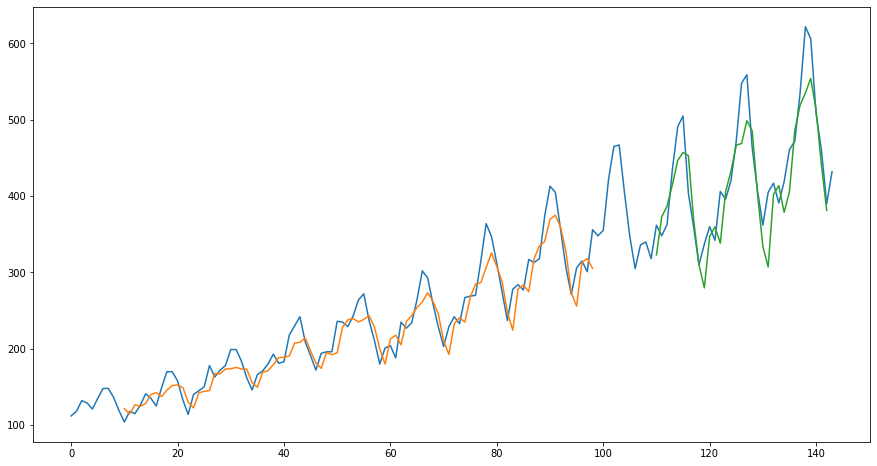

In [550]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[timestamp:len(trainPredict)+timestamp, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(timestamp*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### co jeszcze można???

![image.png](attachment:image.png)

### Links

1. https://www.youtube.com/watch?v=VYpAodcdFfA
2. https://pypi.org/project/pmdarima/
3. https://www.kaggle.com/cihanerman/passenger-forecasting-with-lstm
4. https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
5. http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/03/03_TrendSeasonTS_Python_updated.html
6. https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c6c63703-762d-48f4-8387-054fe9644d63' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>